In [5]:
import os
from os.path import exists
os.environ['OMP_NUM_THREADS'] = '1'
import glob
import sys
sys.path.append(os.path.join(os.getcwd(), *tuple(['..'])))
import argparse
import glob
import json
import pdb
import numpy as np
from skimage import draw
import matplotlib.pyplot as plt
import argparse
import pyfiglet
from skimage import measure
from tqdm import tqdm
from PIL import Image
import pyvips as Vips
from torchvision import transforms
import torchvision
import cv2
from shapely.geometry import Polygon
from shapely import box as shapely_box
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import datasets, models, transforms

In [2]:
from models_pytorch_lightning.model_mrcnn_config import _default_mrcnn_config, build_default
from features import build_features
from models_pytorch_lightning.generalized_mask_rcnn_pl import LitMaskRCNN
from features import transforms as T
import torch

In [3]:
class_names = ["Cored","Diffuse","Coarse-Grained","CAA"]
test_config = dict(batch_size = 1,num_classes=4, device_id =0)
model_name= "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/yp2mf3i8_epoch=108-step=872.ckpt"
model_config = _default_mrcnn_config(num_classes=1 + test_config['num_classes']).config
model = LitMaskRCNN.load_from_checkpoint(model_name)

/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'rpn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rpn'])`.
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'roi_heads' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['roi_heads'])`.
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/u

In [4]:
device = torch.device('cuda', test_config['device_id'])
model = model.to(device)
model.eval()

LitMaskRCNN(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256,

In [5]:
ID_MASK_SHAPE = (1024, 1024)

# Color Coding
lablel2id = {'Cored':'50', 'Diffuse':'100',
             'Coarse-Grained':'150', 'CAA': '200', 'Unknown':'0'}

DATASET_PATH = "/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/Datasets/amyb_wsi"

In [6]:
def save_img(img, file_name, tileX, tileY, label="mask"):
    im = Image.fromarray(img)

    base_name_with_ext = os.path.basename(file_name)

    # Remove the extension to get the folder name
    folder_name = os.path.splitext(base_name_with_ext)[0]

    folder_name = os.path.join(DATASET_PATH, folder_name)

    # Create the new folder only if it does not exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Mask Folder
    save_dir = os.path.join(folder_name, label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_name = file_name + "_" + str(tileX) + "x" + "_" + str(tileY) + "y" + "_" + label + ".png"

    save_name = os.path.join(save_dir, file_name)
    im.save(save_name)

In [7]:
def polygon2id(image_shape, mask, ids, coords_x, coords_y):
    vertex_row_coords, vertex_col_coords = coords_y, coords_x
    fill_row_coords, fill_col_coords = draw.polygon(
        vertex_row_coords, vertex_col_coords, image_shape)

    # Row and col are flipped
    mask[fill_col_coords, fill_row_coords] = ids
    return mask

def polygon2mask1(image_shape, mask, color, coords_x, coords_y):
    """Compute a mask with labels having different colors
    from polygon.
    Parameters
    ----------
    image_shape : tuple of size 2.
        The shape of the mask.
    coords_x: X coordinates
    coords_y: Y coordinates
    mask : Mask with same size of the image (initially empty
    mask is given as input)
    Returns
    -------
    mask : 2-D ndarray of type 'bool'.
        The mask that corresponds to the input polygon.
    """

    vertex_row_coords, vertex_col_coords = coords_x, coords_y
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, image_shape)

    # Row and col are flipped
    mask[fill_col_coords, fill_row_coords] = color

    # mask[fill_row_coords, fill_col_coords] = color
    return mask



def get_vips_info(vips_img):
    # # Get bounds-x and bounds-y offset
    vfields = [f.split('.') for f in vips_img.get_fields()]
    vfields = [f for f in vfields if f[0] == 'openslide']
    vfields = dict([('.'.join(k[1:]), vips_img.get('.'.join(k))) for k in vfields])

    return vfields

In [8]:
def prepare_input(image):
    image_float_np = np.float32(image) / 255
    # define the torchvision image transforms
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #transforms.Normalize([0.8883, 0.8769, 0.8431],[0.1425, 0.1589, 0.2029])
    ])
    input_tensor = transform(image)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_tensor = input_tensor.to(device)
    # Add a batch dimension
    input_tensor = input_tensor.unsqueeze(0)
    return input_tensor, image_float_np

In [9]:
def get_output(outputs, threshold ):
    i =0 
    pred_boxes =outputs[i]["boxes"].cpu().detach().numpy()
    pred_class_ids = outputs[i]["labels"].cpu().detach().numpy()
    pred_scores = outputs[i]["scores"].cpu().detach().numpy()
    pred_masks = outputs[i]["masks"][pred_scores>=threshold]
    pred_masks=pred_masks.squeeze(1).permute(2, 1, 0)
    pred_masks = pred_masks.cpu().detach().numpy()
    pred_boxes =pred_boxes[pred_scores>=threshold]
    pred_class_ids = pred_class_ids[pred_scores>=threshold]
    pred_scores = pred_scores[pred_scores>=threshold]
    return pred_scores,pred_class_ids,pred_masks,pred_boxes

In [10]:
def draw_boxes(boxes, image,gt_class, pred_class, rater_name):
    #for i, box in enumerate(boxes):
        #color = self.colors[labels[i]-1]
    cv2.rectangle(
        image,
        (int(boxes[0]), int(boxes[1])),
        (int(boxes[2]), int(boxes[3])),
        (0,0,0), 2
    )
    cv2.putText(image , "gt:"+gt_class+"_"+"pred:"+pred_class+"_"+rater_name, (int(boxes[0]), int(boxes[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    return image
    

In [11]:
def get_match(img, json_file_name, threshold =0.5):
    vips_img = Vips.Image.new_from_file(img, level=0)
    vinfo = get_vips_info(vips_img)

    # Get the corresponding json file
    json_file_name = os.path.basename(img).split(".mrxs")[0] + ".json"
    json_file_name = os.path.join(json_path, json_file_name)

    #if not exists(json_file_name):
    #    return

    with open(json_file_name) as f:
        data = json.load(f)
        

    actual_labels= []   
    raters = []
    pred_labels = []
    object_names = []
    k=0
    
    for tileId, ele in data.items():
        # print("****************", tileId)
        tileId = tileId.replace("[", "")
        tileId = tileId.replace("]", "")
        tileX = int(tileId.split(",")[0])
        tileY = int(tileId.split(",")[1])
        tileWidth = 1024
        tileHeight = 1024

        tileX = (tileX * tileWidth) + int(vinfo['bounds-x'])
        tileY = (tileY * tileHeight) + int(vinfo['bounds-y'])
            
        vips_img_crop = vips_img.crop(tileX, tileY, tileWidth, tileHeight)

        vips_img_crop = np.ndarray(buffer=vips_img_crop.write_to_memory(), dtype=np.uint8,
                                    shape=(vips_img_crop.height, vips_img_crop.width, vips_img_crop.bands))[..., :3]

        x1 = tileX - int(vinfo['bounds-x'])
        x2 = tileX + tileWidth - int(vinfo['bounds-x'])
        y1 = tileY - int(vinfo['bounds-y'])
        y2 = tileY + tileHeight - int(vinfo['bounds-y'])
        
        input_tensor, image_float_np = prepare_input(vips_img_crop)
        outputs = model.forward(input_tensor)
        #print(len(outputs))
        pred_scores,pred_class_ids,pred_masks,pred_boxes=get_output(outputs,0.75)

        pred_boxes_cnt =  [np.int32(np.array([[box[0],box[1]],[box[0],box[3]],[box[2],box[3]],[box[2],box[1]]])) for box in pred_boxes]
        #print("pred_boxes", pred_boxes_cnt)

        for region in ele:
            if 'label' in region.keys():
                x_bound = region["region_attributes"][0]['tiles'][0]["tileBounds"]['XY'][0]
                y_bound = region["region_attributes"][0]['tiles'][0]["tileBounds"]['XY'][1]
                region_points = region["region_attributes"][0]["points"]
                region_points = [ [p[0]-x_bound, p[1]-y_bound] for p in region_points]
                #print(region["raterName"], len(region_points))
                mean_reg = np.mean(region_points, axis=0)
                for i, box in enumerate(pred_boxes_cnt):
                    polygon1 = Polygon(np.array(region_points,dtype=np.int32))
                    polygon2 = Polygon(box)
                        # Check for intersection
                    if polygon1.intersects(polygon2):
                        #matches=matches+1
                        #matched_list.append(region["object_name"])
                        actual_labels.append(region['label']['name'])
                        raters.append(region["raterName"])
                        pred_labels.append(class_names[pred_class_ids[i]-1])
                        if "object_name" in region.keys():
                            object_names.append(region["object_name"])
                        else:
                            object_names.append(None)
                    
                        if region['label']['name']!=class_names[pred_class_ids[i]-1]:
                            k=k+1
                            vips_img_crop1=vips_img_crop.copy()
                            #vips_img_crop1 = data_transforms["test"](vips_img_crop1)
                            #vips_img_crop1 = torch.permute(vips_img_crop1,(2,0,1))
                            vips_img_crop1 = np.ascontiguousarray(vips_img_crop1, dtype=np.uint8)
                            image = draw_boxes(pred_boxes[i], vips_img_crop1, region['label']['name'], class_names[pred_class_ids[i]-1], region["raterName"])
                            image1 = Image.fromarray(image)
                            image1.save("/home/mahirwar/Desktop/Monika/npsad_data/vivek/model_analysis/test-interrater/"+json_file_name.split("/")[-1]+str(tileId)+"_"+str(k)+".png")
    return actual_labels,raters,pred_labels,object_names


    #    break

In [12]:
json_path = "/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-test-jsons/all_raters"
json_files = glob.glob(os.path.join(json_path,"*"))
json_files = [x.split("/")[-1] for x in json_files]
imgs = [os.path.join("/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/amy-def-mfg-images/",x.replace("json","mrxs")) for x in json_files]

In [16]:
actual_labels_all= []
raters_all = []
pred_labels_all = []
object_name_all= []
imgs_all = []

for img, json_file_name in zip(imgs,json_files):
    actual_labels,raters,pred_labels, object_names= get_match(img, json_file_name,0.73)
    actual_labels_all.extend(actual_labels)
    raters_all.extend(raters)
    pred_labels_all.extend(pred_labels)
    object_name_all.extend(object_names)
    imgs_all.extend([img.split("/")[-1]]*len(actual_labels))

In [17]:
df = pd.DataFrame({"pred_labels":pred_labels_all,"actual_label":actual_labels_all, "rater_name":raters_all,"object_names":object_name_all,"img_name":imgs_all})

In [18]:
df

,pred_labels,actual_label,rater_name,object_names,img_name
0,Diffuse,Diffuse,Monika,8:Diffuse,XE18-066_1_AmyB_1.mrxs
1,Diffuse,Diffuse,Monika,8:Diffuse,XE18-066_1_AmyB_1.mrxs
2,Diffuse,Diffuse,Monika,9:Diffuse,XE18-066_1_AmyB_1.mrxs
3,Diffuse,Diffuse,Monika,9:Diffuse,XE18-066_1_AmyB_1.mrxs
4,Coarse-Grained,Coarse-Grained,Monika,5:Coarse-Grained,XE18-066_1_AmyB_1.mrxs
...,...,...,...,...,...
453,Diffuse,Coarse-Grained,Ceren,45:Coarse-Grained,XE07-049_1_AmyB_1.mrxs
454,Diffuse,Coarse-Grained,Max,45:Coarse-Grained,XE07-049_1_AmyB_1.mrxs
455,Diffuse,Cored,Ceren,36:Cored,XE07-049_1_AmyB_1.mrxs
456,Diffuse,Cored,Max,36:Cored,XE07-049_1_AmyB_1.mrxs


In [19]:
df.groupby(["object_names"])["rater_name"].count()

object_names
0:Coarse-Grained     3
0:Cored              7
10:Coarse-Grained    9
10:Cored             2
10:Diffuse           4
                    ..
8:Coarse-Grained     7
8:Diffuse            4
9:Coarse-Grained     6
9:Cored              2
9:Diffuse            7
Name: rater_name, Length: 137, dtype: int64

In [20]:
df[df["object_names"]!="None"]

,pred_labels,actual_label,rater_name,object_names,img_name
0,Diffuse,Diffuse,Monika,8:Diffuse,XE18-066_1_AmyB_1.mrxs
1,Diffuse,Diffuse,Monika,8:Diffuse,XE18-066_1_AmyB_1.mrxs
2,Diffuse,Diffuse,Monika,9:Diffuse,XE18-066_1_AmyB_1.mrxs
3,Diffuse,Diffuse,Monika,9:Diffuse,XE18-066_1_AmyB_1.mrxs
4,Coarse-Grained,Coarse-Grained,Monika,5:Coarse-Grained,XE18-066_1_AmyB_1.mrxs
...,...,...,...,...,...
453,Diffuse,Coarse-Grained,Ceren,45:Coarse-Grained,XE07-049_1_AmyB_1.mrxs
454,Diffuse,Coarse-Grained,Max,45:Coarse-Grained,XE07-049_1_AmyB_1.mrxs
455,Diffuse,Cored,Ceren,36:Cored,XE07-049_1_AmyB_1.mrxs
456,Diffuse,Cored,Max,36:Cored,XE07-049_1_AmyB_1.mrxs


In [27]:
all_objects = pd.read_csv("/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Amy_plaque_Results/interrater-tool/monika_vivek_interrater_analysis/all_objects_full.csv")

In [ ]:
def count_nonNa_consensus(l):
    common_classes = set([l["monika_class"], l["max_class"],l["ceren_class"],l["vivek_class"]])
    if "None" in common_classes:
        
    

In [73]:
all_objects["n_consensus"] = all_objects.apply(lambda l: 5- len(set([l["monika_class"], l["max_class"],l["ceren_class"],l["vivek_class"]])) ,axis=1)

In [75]:
all_objects[all_objects["n_consensus"]==3]

,Unnamed: 0,monika_index,monika_class,monika_object_name,max_index,max_class,max_object_name,geojson_file,ceren_index,ceren_class,ceren_object_name,vivek_index,vivek_class,vivek_object_name,n_consensus
4,4,4.0,Coarse-Grained,17:Coarse-Grained,5.0,Cored,0:Cored,XE11-039_1_AmyB_1.mrxs.geojson,3.0,Cored,13:Cored,3.0,Cored,12:Cored,3
7,8,8.0,Coarse-Grained,23:Coarse-Grained,6.0,Diffuse,10:Diffuse,XE11-039_1_AmyB_1.mrxs.geojson,4.0,Coarse-Grained,18:Coarse-Grained,4.0,Coarse-Grained,15:Coarse-Grained,3
8,12,14.0,Coarse-Grained,2:Coarse-Grained,19.0,Cored,18:Cored,XE11-039_1_AmyB_1.mrxs.geojson,23.0,Cored,27:Cored,9.0,Cored,0:Cored,3
10,14,16.0,Coarse-Grained,5:Coarse-Grained,28.0,Cored,27:Cored,XE11-039_1_AmyB_1.mrxs.geojson,32.0,Cored,1:Cored,15.0,Coarse-Grained,6:Coarse-Grained,3
13,18,20.0,Coarse-Grained,1:Coarse-Grained,24.0,Cored,25:Cored,XE11-039_1_AmyB_1.mrxs.geojson,29.0,Cored,2:Cored,13.0,Cored,2:Cored,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,121,0.0,Diffuse,20:Diffuse,48.0,Diffuse,4:Diffuse,XE18-003_1_AmyB_1.mrxs.geojson,49.0,Diffuse,5:Diffuse,NaN,None,NaN,3
377,122,0.0,Diffuse,20:Diffuse,49.0,Diffuse,5:Diffuse,XE18-003_1_AmyB_1.mrxs.geojson,44.0,Diffuse,17:Diffuse,NaN,None,NaN,3
378,123,0.0,Diffuse,20:Diffuse,49.0,Diffuse,5:Diffuse,XE18-003_1_AmyB_1.mrxs.geojson,48.0,Diffuse,4:Diffuse,NaN,None,NaN,3
379,175,21.0,Coarse-Grained,15:Coarse-Grained,8.0,Coarse-Grained,9:Coarse-Grained,XE18-066_1_AmyB_1.mrxs.geojson,8.0,Coarse-Grained,15:Coarse-Grained,NaN,None,NaN,3


In [155]:
all_matched_objects = all_objects[(all_objects["monika_class"]==all_objects["max_class"]) & (all_objects["ceren_class"]==all_objects["vivek_class"]) & (all_objects["max_class"] == all_objects["ceren_class"] )& (all_objects["monika_class"]!='None' )]

In [96]:
consensus_3 = all_objects[all_objects["n_consensus"]>=3]

In [156]:
common_monika_objects =  list(all_matched_objects["monika_object_name"].values)

In [97]:
common_monika_objects =  list(consensus_3["monika_object_name"].values)

In [157]:
len(common_monika_objects)

85

In [158]:
df["common_flag"] = df.apply(lambda l: 1 if (l["rater_name"]=="Monika") and (l["object_names"] in common_monika_objects) else 0, axis=1)

In [159]:
df_monika_common = df[df["common_flag"]==1]

In [160]:
df_monika_common

,pred_labels,actual_label,rater_name,object_names,img_name,common_flag
4,Coarse-Grained,Coarse-Grained,Monika,5:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
5,Coarse-Grained,Coarse-Grained,Monika,6:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
6,Diffuse,Diffuse,Monika,7:Diffuse,XE18-066_1_AmyB_1.mrxs,1
7,Coarse-Grained,Coarse-Grained,Monika,3:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
8,Diffuse,Diffuse,Monika,20:Diffuse,XE18-066_1_AmyB_1.mrxs,1
...,...,...,...,...,...,...
393,Diffuse,Diffuse,Monika,22:Diffuse,XE07-049_1_AmyB_1.mrxs,1
405,Cored,Cored,Monika,1:Cored,XE07-049_1_AmyB_1.mrxs,1
427,Diffuse,Diffuse,Monika,20:Diffuse,XE07-049_1_AmyB_1.mrxs,1
431,Cored,Cored,Monika,19:Cored,XE07-049_1_AmyB_1.mrxs,1


In [18]:
raters = df["rater_name"].unique()

Rater Monika
[[ 0  0  0  0]
 [ 0 35  2 28]
 [ 1  3  9  7]
 [ 0  0  0 41]]
0.6746031746031746


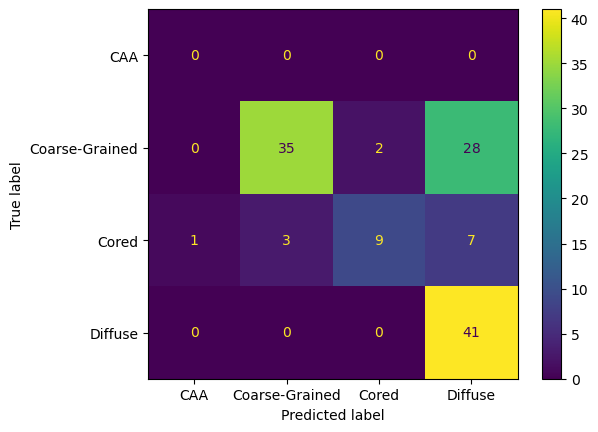

In [61]:
for rater in raters:
    df_max= df[(df["rater_name"]==rater) ]
    #if len(df_max)>0:
    print("Rater", rater)
    conf_mat = confusion_matrix(df_max["actual_label"],df_max["pred_labels"])
    print(conf_mat)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                display_labels=['CAA','Coarse-Grained','Cored', 'Diffuse'])
    disp.plot()
    print(np.trace(conf_mat)/np.sum(conf_mat))
    break

Rater Max
[[ 0  0  0  0]
 [ 1 47  0 43]
 [ 1  8 12  5]
 [ 0  1  0 76]]
0.6958762886597938
Rater Ceren
[[ 0  0  0  0]
 [ 0 40  0 45]
 [ 2  9 10  3]
 [ 0  0  0 73]]
0.6758241758241759
Rater Vivek
[[ 0  0  0  0]
 [ 0 26  0 21]
 [ 1  5 11  4]
 [ 0  0  0 17]]
0.6352941176470588
Rater Monika
[[ 0  0  0  0]
 [ 0 35  2 28]
 [ 1  3  9  7]
 [ 0  0  0 41]]
0.6746031746031746


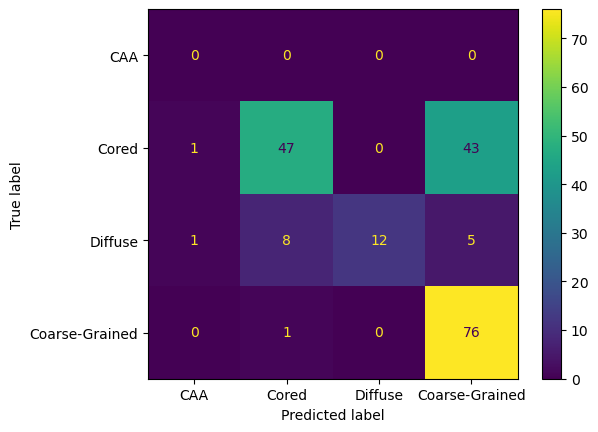

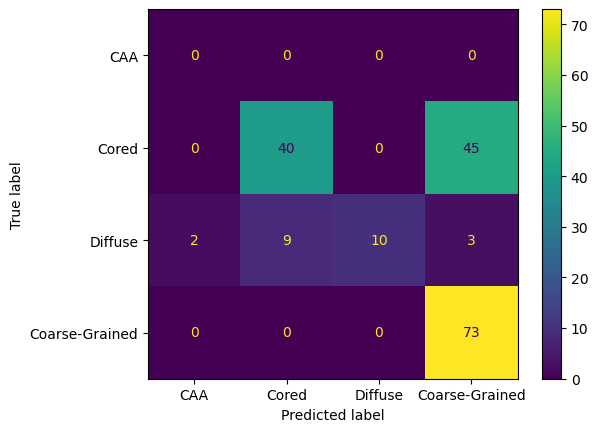

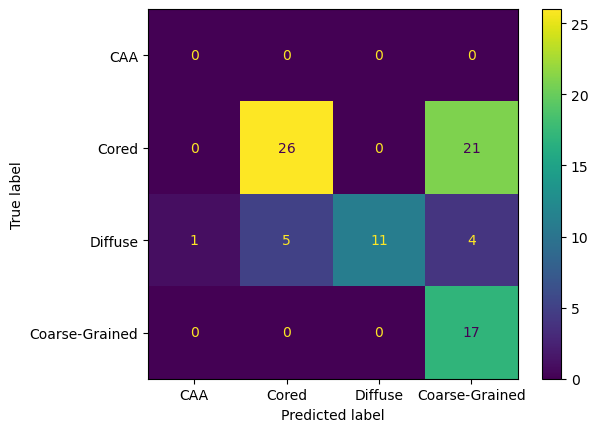

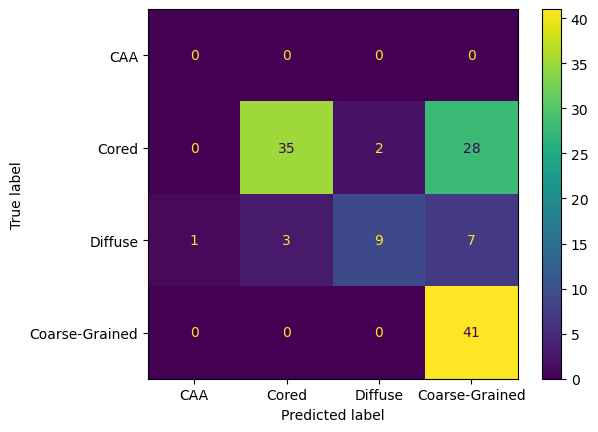

In [20]:
for rater in raters:
    df_max= df[(df["rater_name"]==rater) ]
    #if len(df_max)>0:
    print("Rater", rater)
    conf_mat = confusion_matrix(df_max["actual_label"],df_max["pred_labels"])
    print(conf_mat)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                display_labels=['CAA','Cored', 'Diffuse', 'Coarse-Grained'])
    disp.plot()
    print(np.trace(conf_mat)/np.sum(conf_mat))
    #break
    

In [21]:
len(df[(df["pred_labels"]=="Diffuse") & (df["actual_label"]=="Diffuse")])


207

In [22]:
len(df[(df["pred_labels"]=="Cored") & (df["actual_label"]=="Cored")])

42

In [23]:
len(df[(df["pred_labels"]=="Coarse-Grained") & (df["actual_label"]=="Coarse-Grained")])

148

In [24]:
conf_mat = confusion_matrix(df["actual_label"],df["pred_labels"], labels=['CAA','Cored', 'Diffuse', 'Coarse-Grained'])
conf_mat

array([[  0,   0,   0,   0],
       [  5,  42,  19,  25],
       [  0,   0, 207,   1],
       [  1,   2, 137, 148]])

[[ 0  0  0  0]
 [ 0 35  2 24]
 [ 1  3  9  4]
 [ 0  0  0 39]]
0.7094017094017094


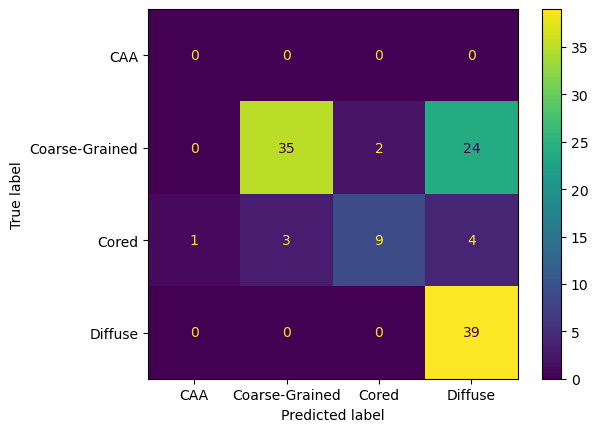

In [102]:
#for rater in raters:
#df_max= df[(~df["object_names"].isna())]
#if len(df_max)>0:
#print("Rater", rater)
conf_mat = confusion_matrix(df_monika_common["actual_label"],df_monika_common["pred_labels"] )
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                            display_labels=[ 'CAA','Coarse-Grained', 'Cored','Diffuse'])
disp.plot()
print(np.trace(conf_mat)/np.sum(conf_mat))
    #break

In [57]:
len(df_monika_common[(df_monika_common["pred_labels"]=="Diffuse") & (df_monika_common["actual_label"]=="Diffuse")])


16

In [58]:
len(df_monika_common[(df_monika_common["pred_labels"]=="Cored") & (df_monika_common["actual_label"]=="Cored")])

8

In [54]:
df_monika_common[df_monika_common["pred_labels"]!=df_monika_common["actual_label"]]

,pred_labels,actual_label,rater_name,object_names,img_name,common_flag
10,Diffuse,Coarse-Grained,Monika,14:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
11,Diffuse,Coarse-Grained,Monika,15:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
20,Diffuse,Coarse-Grained,Monika,56:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
21,Diffuse,Coarse-Grained,Monika,54:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
23,Coarse-Grained,Cored,Monika,29:Cored,XE18-066_1_AmyB_1.mrxs,1
25,Diffuse,Coarse-Grained,Monika,40:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
26,Diffuse,Coarse-Grained,Monika,55:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
49,Diffuse,Coarse-Grained,Monika,48:Coarse-Grained,XE19-037_1_AmyB_1.mrxs,1
55,Diffuse,Coarse-Grained,Monika,32:Coarse-Grained,XE19-037_1_AmyB_1.mrxs,1
91,Diffuse,Coarse-Grained,Monika,4:Coarse-Grained,XE19-037_1_AmyB_1.mrxs,1


In [52]:
df_monika_common[df_monika_common["pred_labels"]==df_monika_common["actual_label"]]

,pred_labels,actual_label,rater_name,object_names,img_name,common_flag
4,Coarse-Grained,Coarse-Grained,Monika,5:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
5,Coarse-Grained,Coarse-Grained,Monika,6:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
6,Diffuse,Diffuse,Monika,7:Diffuse,XE18-066_1_AmyB_1.mrxs,1
7,Coarse-Grained,Coarse-Grained,Monika,3:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
8,Diffuse,Diffuse,Monika,20:Diffuse,XE18-066_1_AmyB_1.mrxs,1
9,Diffuse,Diffuse,Monika,21:Diffuse,XE18-066_1_AmyB_1.mrxs,1
12,Diffuse,Diffuse,Monika,16:Diffuse,XE18-066_1_AmyB_1.mrxs,1
13,Diffuse,Diffuse,Monika,1:Diffuse,XE18-066_1_AmyB_1.mrxs,1
14,Coarse-Grained,Coarse-Grained,Monika,10:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
16,Diffuse,Diffuse,Monika,30:Diffuse,XE18-066_1_AmyB_1.mrxs,1


In [138]:
consensus_2 = all_objects[all_objects["n_consensus"]>=3]

In [139]:
len(consensus_2)

350

In [140]:
common_monika_objects =  list(consensus_2["max_object_name"].values)

In [141]:
len(common_monika_objects)

350

In [142]:
df["common_flag"] = df.apply(lambda l: 1 if (l["rater_name"]=="Max") and (l["object_names"] in common_monika_objects) else 0, axis=1)

In [150]:
df

,pred_labels,actual_label,rater_name,object_names,img_name,common_flag
0,Diffuse,Diffuse,Monika,8:Diffuse,XE18-066_1_AmyB_1.mrxs,0
1,Diffuse,Diffuse,Monika,8:Diffuse,XE18-066_1_AmyB_1.mrxs,0
2,Diffuse,Diffuse,Monika,9:Diffuse,XE18-066_1_AmyB_1.mrxs,0
3,Diffuse,Diffuse,Monika,9:Diffuse,XE18-066_1_AmyB_1.mrxs,0
4,Coarse-Grained,Coarse-Grained,Monika,5:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,0
...,...,...,...,...,...,...
453,Diffuse,Coarse-Grained,Ceren,45:Coarse-Grained,XE07-049_1_AmyB_1.mrxs,0
454,Diffuse,Coarse-Grained,Max,45:Coarse-Grained,XE07-049_1_AmyB_1.mrxs,1
455,Diffuse,Cored,Ceren,36:Cored,XE07-049_1_AmyB_1.mrxs,0
456,Diffuse,Cored,Max,36:Cored,XE07-049_1_AmyB_1.mrxs,1


In [151]:
df_max_common = df[(df["common_flag"]==1) ]

In [152]:
len(df_max_common)

132

In [153]:
df_max_common = df[(df["common_flag"]==1) & (df_max_common["img_name"]!="XE18-066_1_AmyB_1.mrxs")]

In [154]:
len(df_max_common)

132

In [148]:
df_max_common["img_name"].unique()

array(['XE19-037_1_AmyB_1.mrxs', 'XE11-039_1_AmyB_1.mrxs',
       'XE18-003_1_AmyB_1.mrxs', 'XE07-049_1_AmyB_1.mrxs'], dtype=object)

In [167]:
df_monika_common2 = df_monika_common2[ (df_monika_common2["img_name"]!="XE19-037_1_AmyB_1.mrxs")]

[[15  1  3]
 [ 1  6  0]
 [ 0  0  7]]
0.8484848484848485


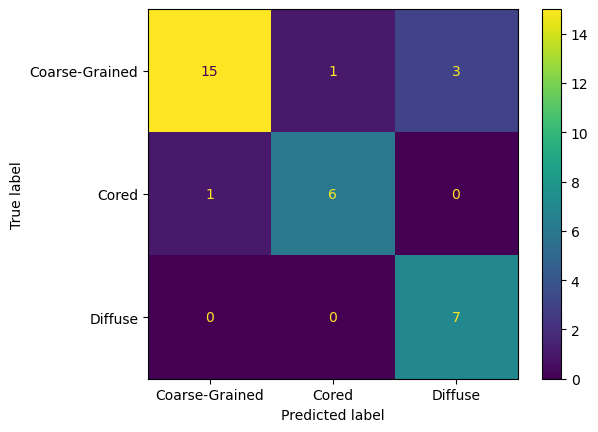

In [168]:
conf_mat = confusion_matrix(df_monika_common2["actual_label"],df_monika_common2["pred_labels"] )
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                            display_labels=['Coarse-Grained', 'Cored','Diffuse'])
disp.plot()
print(np.trace(conf_mat)/np.sum(conf_mat))

In [163]:
df_monika_common[df_monika_common["pred_labels"]==df_monika_common["actual_label"]]

,pred_labels,actual_label,rater_name,object_names,img_name,common_flag
4,Coarse-Grained,Coarse-Grained,Monika,5:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
5,Coarse-Grained,Coarse-Grained,Monika,6:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
6,Diffuse,Diffuse,Monika,7:Diffuse,XE18-066_1_AmyB_1.mrxs,1
7,Coarse-Grained,Coarse-Grained,Monika,3:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
8,Diffuse,Diffuse,Monika,20:Diffuse,XE18-066_1_AmyB_1.mrxs,1
9,Diffuse,Diffuse,Monika,21:Diffuse,XE18-066_1_AmyB_1.mrxs,1
12,Diffuse,Diffuse,Monika,16:Diffuse,XE18-066_1_AmyB_1.mrxs,1
13,Diffuse,Diffuse,Monika,1:Diffuse,XE18-066_1_AmyB_1.mrxs,1
14,Coarse-Grained,Coarse-Grained,Monika,10:Coarse-Grained,XE18-066_1_AmyB_1.mrxs,1
16,Diffuse,Diffuse,Monika,30:Diffuse,XE18-066_1_AmyB_1.mrxs,1
